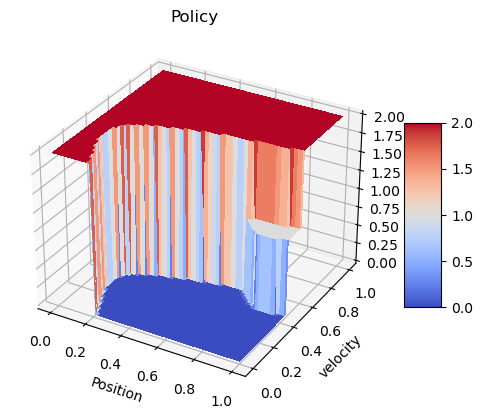

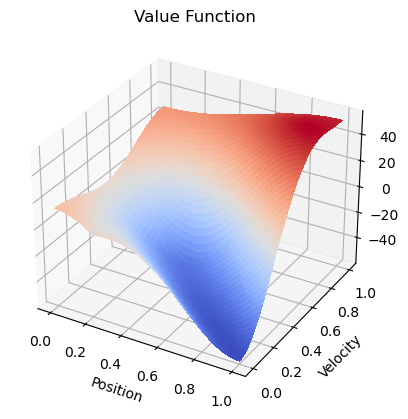

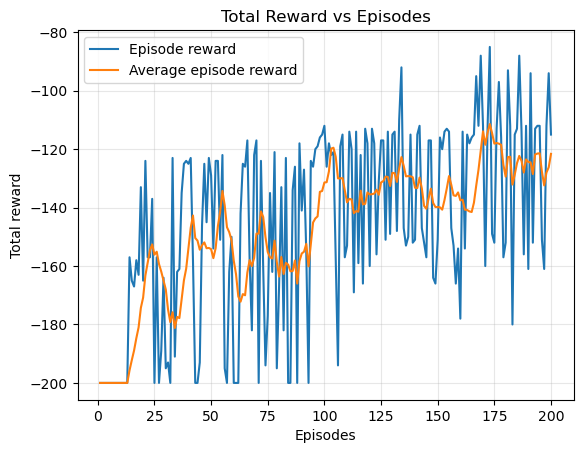

In [1]:
# Mohammed Akif (990123-4493)
# Kevin Armbruster (930519-T711)

# Copyright [2020] [KTH Royal Institute of Technology] Licensed under the
# Educational Community License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may
# obtain a copy of the License at http://www.osedu.org/licenses/ECL-2.0
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an "AS IS"
# BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express
# or implied. See the License for the specific language governing
# permissions and limitations under the License.
#
# Course: EL2805 - Reinforcement Learning - Lab 1 Problem 4
# Code author: [Alessio Russo - alessior@kth.se]
# Last update: 6th October 2020, by alessior@kth.se
#

# Load packages
import numpy as np
import gym
import torch
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

# Parameters
N_episodes = 200        # Number of episodes to run for training
#eta = np.array([[1,0],[0,1],[1,1],[2,0],[0,2],[1,2],[2,1],[2,2]]).T
eta = np.array([[0,1],[1,0],[1,1],[1,2],[2,0],[2,2]]).T
alpha_init = 0.01/np.maximum(np.linalg.norm(eta, axis=0), 1).reshape(-1,1) # Initial scaled learning rate
alpha_factor = 1        # Scale factor 
lambd_a = 0.74           # Eligibility parameter
gamma = 1               # Discount factor
epsilon_init = 0.3      # Initial value for epsilon-Greedy Action Selection
w = 0.1*np.random.randn(eta.shape[1],3)      # Initial weights genrated from the standard normal dist.
z = np.zeros_like(w)
v = z
m = 0.1 # Momentum

# Reward
episode_reward_list = []  # Used to save episodes reward


# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x

def Q(s):
    phi = np.cos(np.pi*np.dot(eta.T,s))
    q = np.dot(w.T,phi)
    return q

def epsilon_greedy_action_selection(s, epsilon):
    ''' Choose between exploration and exploitation randomly'''
    p = np.random.rand()
    if (p < epsilon):
        action = np.random.randint(0, k)
    else:
        action = np.argmax(Q(s))
    return action

def reduce_alpha(scale_factor):
    ''' If better rewards are achieved, alpha is scaled down '''
    if (episode_reward_list == []):
        return scale_factor
    else:
        min_factor = 1
        if (episode_reward_list[-1] > -100):
            min_factor = 0.1
        elif (episode_reward_list[-1] > -130):
            min_factor = 0.4
        elif (episode_reward_list[-1] > -150):
            min_factor = 0.7
        
        scale_factor = min(min_factor, scale_factor)
        return scale_factor

def gradient_Q(s, a):
    gradient = np.zeros_like(z)
    phi = np.cos(np.pi*np.dot(eta.T,s))
    gradient[:, a] = phi
    return gradient


# Training process
for i in range(N_episodes):
    # Reset enviroment data
    done = False
    state = scale_state_variables(env.reset())
    total_episode_reward = 0.
    z[:,:] = 0
    v[:,:] = 0
    epsilon_factor = 1-(0.1*(i//(0.1*N_episodes)))  # Factor for reducing the exploration rate
    epsilon = epsilon_init*epsilon_factor

    # Epsilon-Greedy Action Selection
    action = epsilon_greedy_action_selection(state, epsilon)

    while not done:
        # Take a random action
        # env.action_space.n tells you the number of actions
        # available
        #action = np.random.randint(0, k)
            
        # Get next state and reward.  The done variable
        # will be True if you reached the goal position,
        # False otherwise
        next_state, reward, done, _ = env.step(action)
        next_state = scale_state_variables(next_state)

        # Reduce learning rate alpha when rewards are increased 
        alpha_factor = reduce_alpha(alpha_factor)
        alpha = alpha_init*alpha_factor

        # Epsilon-Greedy Action Selection
        next_action = epsilon_greedy_action_selection(next_state, epsilon)

        #  Update the eligibility trace z and the parameter w
        delta = reward + gamma*Q(next_state)[next_action] - Q(state)[action]  # temporal difference error
        z = gamma*lambd_a*z + gradient_Q(state, action)   # Eligibility trace
        z = np.clip(z, -5, 5)
        # SGD with Nesterov Acceleration.
        v = m*v + alpha*delta*z
        w += m*v + alpha*delta*z

        # Update episode reward
        total_episode_reward += reward
            
        # Update state for next iteration
        state = next_state
        action = next_action

    # Append episode reward
    episode_reward_list.append(total_episode_reward)

    # Close environment
    env.close()   

three_D = True
if three_D:
    s1 = np.linspace(0, 1, 100)
    s2 = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(s1, s2)
    Z1 = np.zeros_like(X)
    Z2 = np.zeros_like(X)
    for i in range(Z1.shape[0]): 
        for j in range(Z1.shape[1]):
            state = np.array([s1[i], s2[j]])
            Z1[j,i] = np.argmax(Q(state))
            Z2[j,i] = np.max(Q(state))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Policy')
    ax.set_xlabel('Position')
    ax.set_ylabel('velocity')
    surf = ax.plot_surface(X,Y,Z1,cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Value Function')
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.plot_surface(X, Y, Z2, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.show()

# Plot Rewards
plt.plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
plt.plot([i for i in range(1, N_episodes+1)], running_average(episode_reward_list, 10), label='Average episode reward')
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.title('Total Reward vs Episodes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

data={'W':w.T, 'N':eta.T}
pickle.dump(data, open("weights.pkl", "wb"))